# Extract ENDF cross sections from GNDS-formatted ENDF files

This '`notebook` demonstrates the process for extracting neutron-capture cross sections from GNDS-formatted ENDF files.  Requires installation of FUDGE (https://github.com/LLNL/fudge). The notebooks is used to create the folders of CSV-formatted capture cross section data from ENDF/B-VIII.1 (downloaded from https://www.nndc.bnl.gov/endf/) in Westcott $g$ factors calculations in this package. 

In [1]:
from fudge import map as fudgeMap
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import glob
import re
import os

In [2]:
# Specify location of GNDS-formatted ENDF data and the location where the CSV capture data will go
# In this example the ENDF/B-VIII.1 library has been downloaded from the NNDC website and unzipped in the current directory
fudgeMap_PATH = './ENDF-B-VIII.1-GNDS/neutrons.map'
ENDF_XML_PATH = './ENDF-B-VIII.1-GNDS/neutrons'
# Create a folder containing CSV files of cross sections, where they will be accessible to the WestcottFactor methods
capture_CSV_PATH = '../westcott/data_capture'
try:
    os.mkdir(capture_CSV_PATH)
except OSError as e:
    print("Error:", e)

In [3]:
# Read in FUDGE map of ENDF/B-8.1 data and return reaction suite
def read_fudgeMap(fudgeMap_path, projectile_type, target_nucleus):
    ENDF81 = fudgeMap.read(fudgeMap_path)
    rxn_suite = ENDF81.find(projectile=projectile_type, target=target_nucleus).read()
    return(rxn_suite)

In [4]:
# Create target list from FUDGE map and ENDF XML files
def create_targetList(ENDF_XML_path):
    # Create list of neutron targets from XML ENDF files
    ENDF_XML_PATH = ENDF_XML_path
    xml_list = [x for x in glob.glob("%s/*.xml"%ENDF_XML_path)]
    n_targets = []
    for xml in xml_list:
        xml_file = xml.split('neutrons/')[1]
        Z = int(xml_file.split('n-')[1].split('_')[0])
        element = xml_file.split('_')[1]
        A = None
        try:
            A = int(xml_file.split('_')[2].split('.')[0])
        except ValueError:
            A = xml_file.split('_')[2].split('.')[0]
            if 'm' in A:
                if A[0]=='0' and A[1]=='0':
                    A = A.strip(A[0:2])
                elif A[0]=='0':
                    A = A.strip(A[0:1])
                else:
                    pass
                A = A.replace('m','_m')

        n_targets.append(element+str(A))
    n_targets = sorted(n_targets)
    print("List object contains {0} n-reaction targets from XML-formatted ENDF libraries.\n".format(len(n_targets)))
    print(n_targets)
    return n_targets

In [5]:
# Define target directory to write and store capture-gamma cross-section CSV data. 
def create_sigma_csv(n_targets, fudgeMap_path, capture_data_path):
    # Define target directory for CSV files to go
    TARGETDIR_CAPTURE = capture_data_path
    columns = ['energy [eV]', 'cross section [b]']

    # Read in target data and write CSV files, ignoring n+n1 and (for now) n+U238 due to parsing problems
    for t in n_targets:
        if t!='n1' and t!='U238':
            RS = read_fudgeMap(fudgeMap_path,'n',t)
            cs_data = None

            # Do some regex on target label
            letters_pattern = r'\D+'
            numbers_pattern = r'\d+'
            chem_symbol = str(re.findall(letters_pattern, t)[0])
            target_mass = int(re.findall(numbers_pattern, t)[0])
            residual_mass = target_mass+1
            residual = str(chem_symbol)+str(residual_mass)
            print(residual)

            for reaction in RS:
                if str('{0} + photon [inclusive]'.format(residual)) in reaction.label:
                    try:
                        crossSection = reaction.crossSection.evaluated.toPointwise_withLinearXYs(accuracy=1e-3, lowerEps=1e-8)
                        cs_data = crossSection
                    except:
                        print(f"Could not extract cross section for reaction '{reaction.label}'!")

            # Extract pointwise cross-section data from `cs_data` object into a new DataFrame:
            try:
                df_cs = pd.DataFrame(list(cs_data), columns=columns)
                df_cs.to_csv("{0}/n-capture-{1}.csv".format(TARGETDIR_CAPTURE,t), index=False)
            except TypeError:
                if cs_data is None:
                    print("Reaction suite for target {0}: No (n,g) reaction channel".format(t))
    return

In [6]:
# Get radiative thermal-neutron capture reactions from the RS and return as a pandas DataFrame
def get_capture_cs(RS):
    cs = None
    for reaction in RS:
        #(n,g) reactions are identified with '(A+1)Z + photon [inclusive]'
        if str('+ photon [inclusive]') in reaction.label:
            try:
                cs = reaction.crossSection.evaluated.toPointwise_withLinearXYs(accuracy=1e-3, lowerEps=1e-8)
                columns = ['energy [eV]', 'cross section [b]']
                df = pd.DataFrame(list(cs), columns=columns)
                return df
            except:
                print(f"Could not extract cross section for reaction '{reaction.label}'!")
                return

n + W186 --> n + W186
             n + (W186_e1 -> W186 + photon)
             n + (W186_e2 -> W186 + photon)
             n + (W186_e3 -> W186 + photon)
             n + (W186_e4 -> W186 + photon)
             n + (W186_e5 -> W186 + photon)
             n + (W186_e6 -> W186 + photon)
             n + (W186_e7 -> W186 + photon)
             n + (W186_e8 -> W186 + photon)
             n + (W186_e9 -> W186 + photon)
             n + (W186_e10 -> W186 + photon)
             n + (W186_e11 -> W186 + photon)
             n + W186 + photon [continuum]
             2n + W185 + photon
             3n + W184 + photon
             4n + W183 + photon
             n + H1 + Ta185 + photon
             H1 + Ta186
             H1 + Ta186 + photon [continuum]
             He4 + Hf183
             He4 + Hf183 + photon [continuum]
             W187 + photon [inclusive]
             2n + H1 + Ta184 + photonsumOfRemainingOutputChannels


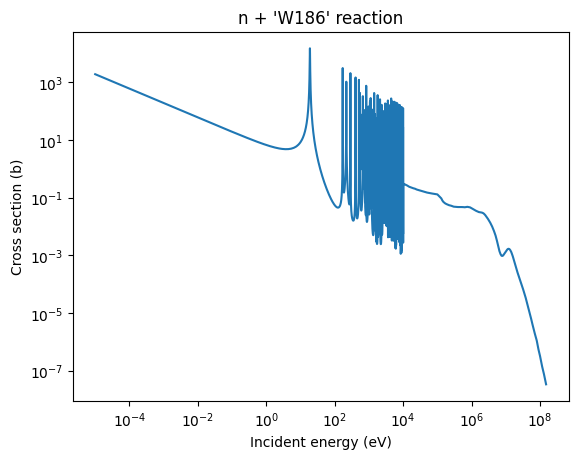

In [7]:
# Test by displaying the reaction suite for a specific nucleus
test_suite = read_fudgeMap(fudgeMap_PATH,'n','W186')
print(test_suite.toString())

# Get (n,g) cross section and plot
cs_dataframe = get_capture_cs(test_suite)
cs_data = cs_dataframe.to_numpy()
plt.loglog(cs_data[:,0], cs_data[:,1])
plt.xlabel(f"Incident energy ({test_suite.domainUnit})")
plt.ylabel("Cross section (b)")
plt.title(f"n + '{test_suite.target}' reaction")
plt.show() 


In [ ]:
# Create CSV files of cross sections and save them to the specified capture data directory
targets = create_targetList(ENDF_XML_PATH)
create_sigma_csv(targets, fudgeMap_PATH, capture_CSV_PATH)

List object contains 558 n-reaction targets from XML-formatted ENDF libraries.

['Ac225', 'Ac226', 'Ac227', 'Ag107', 'Ag108', 'Ag109', 'Ag110_m1', 'Ag111', 'Ag112', 'Ag113', 'Ag114', 'Ag115', 'Ag116', 'Ag117', 'Ag118_m1', 'Al26_m1', 'Al27', 'Am240', 'Am241', 'Am242', 'Am242_m1', 'Am243', 'Am244', 'Am244_m1', 'Ar36', 'Ar37', 'Ar38', 'Ar39', 'Ar40', 'Ar41', 'As73', 'As74', 'As75', 'Au197', 'B10', 'B11', 'Ba130', 'Ba131', 'Ba132', 'Ba133', 'Ba134', 'Ba135', 'Ba136', 'Ba137', 'Ba138', 'Ba139', 'Ba140', 'Be7', 'Be9', 'Bi209', 'Bi210_m1', 'Bk245', 'Bk246', 'Bk247', 'Bk248', 'Bk249', 'Bk250', 'Br79', 'Br80', 'Br81', 'C12', 'C13', 'Ca40', 'Ca41', 'Ca42', 'Ca43', 'Ca44', 'Ca45', 'Ca46', 'Ca47', 'Ca48', 'Cd106', 'Cd107', 'Cd108', 'Cd109', 'Cd110', 'Cd111', 'Cd112', 'Cd113', 'Cd114', 'Cd115_m1', 'Cd116', 'Ce136', 'Ce137', 'Ce137_m1', 'Ce138', 'Ce139', 'Ce140', 'Ce141', 'Ce142', 'Ce143', 'Ce144', 'Cf246', 'Cf247', 'Cf248', 'Cf249', 'Cf250', 'Cf251', 'Cf252', 'Cf253', 'Cf254', 'Cl35', 'Cl36', 'Cl37